In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [11]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)


('2017-08-23',)
2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
precip_results= session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()
# precip_results

# prcp_results = session.query(Measurement.date, Measurement.prcp).\
# filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data_df = pd.DataFrame(precip_results)
precip_data_df.head()

last_12 = pd.DataFrame(precip_results, columns = ['date','precipitation']).set_index('date')
last_12

last_12_sorted = last_12.sort_values(['date'], ascending = True)


In [15]:
# Sort the dataframe by date
# date = [precip_results[0] for precip_result in precip_results[0:]]
# precip= [precip_results[1] for precip_result in precip_results[0:]]
# precip_df= pd.DataFrame(precip_results[0:], columns=['date', 'prcp'] )
# precip_df.set_index('date', inplace=True)
# precip_df.head(5)

![precipitation](Images/precipitation.png)

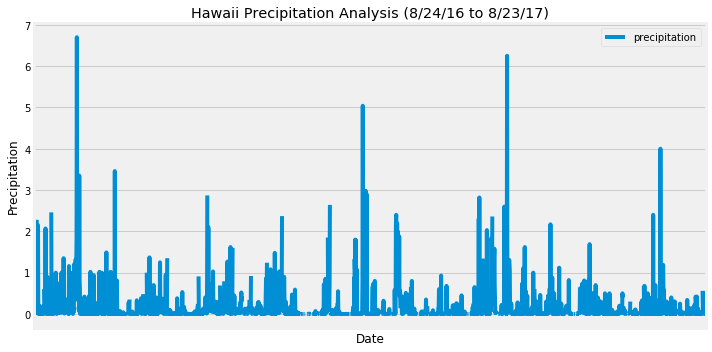

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

# precip_data_df.plot()
last_12_sorted.plot(figsize = (10, 5), title = 'Hawaii Precipitation Analysis (8/24/16 to 8/23/17)')
plt.xticks([])
plt.legend(loc = 'best')
plt.xlabel('Date')
plt.ylabel("Precipitation")
plt.tight_layout()
plt.show()




In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_sorted.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations available.".format(stations))

There are 9 stations available.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.prcp)).\
                                     group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [20]:
Most_active_station = session.query(Measurement.station).\
                                     group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).limit(1).scalar()
print ( "Station with the highest number of observations is  " + str(Most_active_station))



Station with the highest number of observations is  USC00519281


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tobs_results = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()

In [22]:
#query for stats of top station
top_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == "USC00519281").all()
top_station

[(54.0, 85.0, 71.66378066378067)]

In [23]:
#Stats summary for all stations
temp_obs_df = pd.DataFrame(tobs_results)
temp_obs_df.describe()

,tobs
count,2230.000000
mean,74.590583
std,4.611667
min,58.000000
25%,72.000000
50%,75.000000
75%,78.000000
max,87.000000


In [24]:
last_12_clean = last_12_sorted.dropna()
last_12_clean.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature = session.query(Measurement.date,Measurement.tobs).\
            filter(Measurement.date >= one_year_ago).\
            filter(Measurement.station == "USC00519281").all()

temperature

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [26]:
# Convert the temp results of the query into a dataframe to graph
temp_df = pd.DataFrame(np.array(temperature), columns=(["date","tobs"]))
temp_df.head()


,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


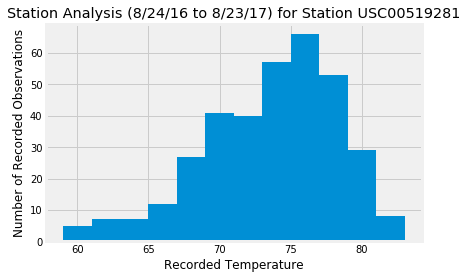

In [27]:

# plot the temperature data in a histogram with 12 bins
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station USC00519281")
plt.show()

![precipitation](Images/station-histogram.png)

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-03-20', '2017-03-30')
trip

[(68.0, 74.22727272727273, 80.0)]

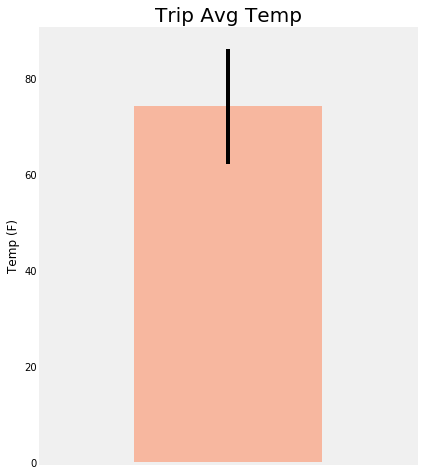

In [40]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("Output/TripTempSummary.png")
plt.show()

In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#set variables to use for analysis
trip_arrive = dt.date(2018, 3, 20)
trip_leave = dt.date(2018, 3, 30)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(68.0, 74.22727272727273, 80.0)]


In [42]:
# set the trip variables of arrive and leave for prior year
lst_year_arrive = trip_arrive - last_year
lst_year_leave = trip_leave - last_year
print(lst_year_arrive)
print(lst_year_leave)

2017-03-20
2017-03-30


In [44]:
# query to pull the rain fall from last year matching this years trip
vacation_data = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= lst_year_arrive).\
    filter(Measurement.date <= lst_year_leave).\
    order_by(Measurement.station).all()

In [47]:

# load the query results into a dataframe and pivot on station
vacation_data_df=pd.DataFrame(vacation_data)

rain_per_station = pd.pivot_table(vacation_data_df,index=['station'],values=['prcp'], aggfunc=sum)
rain_per_station

,prcp
station,
USC00513117,0.84
USC00514830,0.21
USC00516128,1.43
USC00517948,0.00
USC00519281,1.22
USC00519397,0.02
USC00519523,0.60


## Optional Challenge Assignment

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [35]:
# Plot the daily normals as an area plot with `stacked=False`
